## <u>EJERCICIO 1</u>
### **CLASIFICACION CON Red Densa**

### PASO 0 - Importo las librerias y carga del dataset

https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import time
import tensorflow as tf

from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.metrics import MSE
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical

In [38]:
# Utilizaremos solo imagenes de 7 personas con mas de 70 imagenes disponibles.
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=1, color=False, download_if_missing=True)

# Inspeccion de los tamaños
n_samples, h, w = lfw_people.images.shape

# Datos sin divir en subconjuntos
X = lfw_people.images

# Etiquetas y clases
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("h, w: (%d, %d)" % (h, w))
print("n_samples: %d" % n_samples)
print("n_classes: %d" % n_classes)

Total dataset size:
h, w: (125, 94)
n_samples: 1288
n_classes: 7


In [39]:
print(target_names)
print(X.shape)
print(y.shape)
print(y[0])
print(X[0])

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']
(1288, 125, 94)
(1288,)
5
[[0.99607843 0.99607843 0.9986928  ... 0.21699347 0.20261438 0.20653595]
 [0.99607843 0.9973857  0.99607843 ... 0.22222222 0.20261438 0.20653595]
 [0.9986928  0.9973857  0.99346405 ... 0.2248366  0.20522876 0.20522876]
 ...
 [0.3150327  0.29542485 0.2535948  ... 0.39346406 0.37908497 0.37124184]
 [0.29934642 0.2875817  0.2535948  ... 0.38562092 0.38300657 0.38300657]
 [0.27973858 0.27320263 0.25751635 ... 0.38431373 0.38039216 0.38039216]]


In [40]:
#Funciones para graficar
def plot_gallery(images, number, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(number):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

def title(y, target_names):
    return "%s" % (target_names[y])

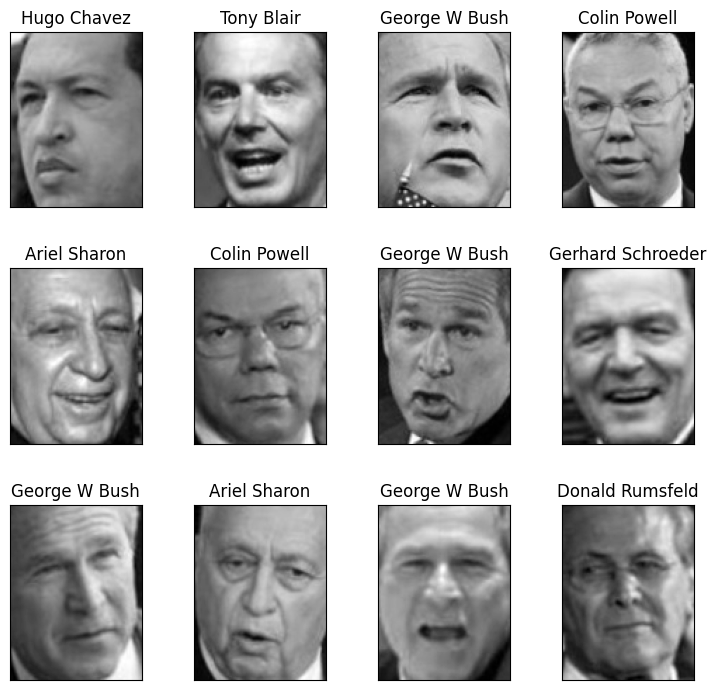

In [41]:
titles = [title(y[i], target_names) for i in range(20)]
plot_gallery(X, 12 , titles, h, w)

In [42]:
print(np.max(X))
print(np.min(X))

1.0
0.0


### PASO 1 - Divido las data en entrenamiento y test

In [43]:
# Division de los datos normalizados

porc_test = 0.25
seed = 8 #8

x_entrenar, x_test, y_entrenar, y_test = train_test_split(X, y, test_size=porc_test, random_state=seed, shuffle=True)
x_testeo = x_test.copy()
print(f"Entrenamiento: {x_entrenar.shape}")
print(f"Testeo: {x_test.shape}")

Entrenamiento: (966, 125, 94)
Testeo: (322, 125, 94)


### PASO 2 - Parametros para entrenamiento y  preparacion de los datos

In [44]:
# Estipulo los parametros para el entrenamiento de la red
lr = 0.001
epochs = 800
batch_size = 40
np.random.seed(9)

# Preparacion de la data - Salida transformada a one-hot
y_entrenar = to_categorical(y_entrenar, n_classes)
y_test = to_categorical(y_test, n_classes)

# Convertir el vector de entrada a una dimension
x_entrenar.shape = (x_entrenar.shape[0], np.prod(x_entrenar.shape[1:]))
x_test.shape = (x_test.shape[0], np.prod(x_test.shape[1:]))

In [45]:
print(x_entrenar.shape)
print(x_test.shape)

(966, 11750)
(322, 11750)


### PASO 3 - Creacion del modelo

In [46]:
# Estructura de la red
input_layer = Input(shape=x_entrenar.shape[1:])
dense_1 = Dense(1000, activation="relu") (input_layer)
dense_2 = Dense(500, activation="relu") (dense_1)
dropout_1 = Dropout(0.1) (dense_2)
dense_4 = Dense(300, activation="relu") (dropout_1)
dense_5 = Dense(300, activation="relu") (dense_4)
dropout_2 = Dropout(0.15) (dense_5)
dense_7 = Dense(100, activation="relu") (dropout_2)
output_layer = Dense(n_classes, activation="softmax") (dense_7)

# Instancia del modelo
modelo = Model(input_layer, output_layer)

In [47]:
optimizador = Adadelta(learning_rate=lr, rho=0.95)
modelo.compile(optimizer=optimizador, loss="categorical_crossentropy", metrics=["acc", "mse"])
modelo.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 11750)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1000)                │      11,751,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 500)                 │         500,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 300)                 │         150,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 300)                 │          90,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 100)                 │          30,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 7)                   │             707 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,522,907 (47.77 MB)

 Trainable params: 12,522,907 (47.77 MB)

 Non-trainable params: 0 (0.00 B)

### PASO 4 - Entrenamiento del modelo

In [48]:
inicio = time.time()
historia = modelo.fit(x_entrenar, y_entrenar, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), shuffle=True, verbose=1)
final = time.time()
print("\nTiempo que demoro el entrenamiento: {:.3f} segundos".format(final-inicio))

Epoch 1/800
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 183ms/step - acc: 0.3305 - loss: 1.8660 - mse: 0.1187 - val_acc: 0.4441 - val_loss: 1.7396 - val_mse: 0.1118
Epoch 2/800
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - acc: 0.3837 - loss: 1.7818 - mse: 0.1139 - val_acc: 0.4441 - val_loss: 1.6705 - val_mse: 0.1071
Epoch 3/800
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.4143 - loss: 1.7110 - mse: 0.1094 - val_acc: 0.4441 - val_loss: 1.6498 - val_mse: 0.1059
Epoch 4/800
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.3945 - loss: 1.7303 - mse: 0.1111 - val_acc: 0.4441 - val_loss: 1.6386 - val_mse: 0.1053
Epoch 5/800
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.3862 - loss: 1.7175 - mse: 0.1102 - val_acc: 0.4441 - val_loss: 1.6295 - val_mse: 0.1049
Epoch 6/800
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.3775 - loss: 1.7345 - mse: 0.1116 - val_acc: 0.4441 - val_loss: 1.6169 - val_mse: 0.1040
Epoch 7/800
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.3807 - loss: 1.7202 - mse: 0.1106 - val_acc:

### PASO 5 - Evaluacion del entrenamiento del modelo

In [49]:
historia.history.keys()

dict_keys(['acc', 'loss', 'mse', 'val_acc', 'val_loss', 'val_mse'])

In [50]:
def grafico_comprobacion(train, test, minimo, maximo):

    plt.plot(historia.history[train], linewidth=1, label="Entrenamiento")
    plt.plot(historia.history[test], linewidth=1, label="Testeo")
    plt.xlabel("Epochs")
    plt.ylabel("MSE")
    plt.axis([0, epochs, minimo, maximo])
    plt.legend(loc="best")

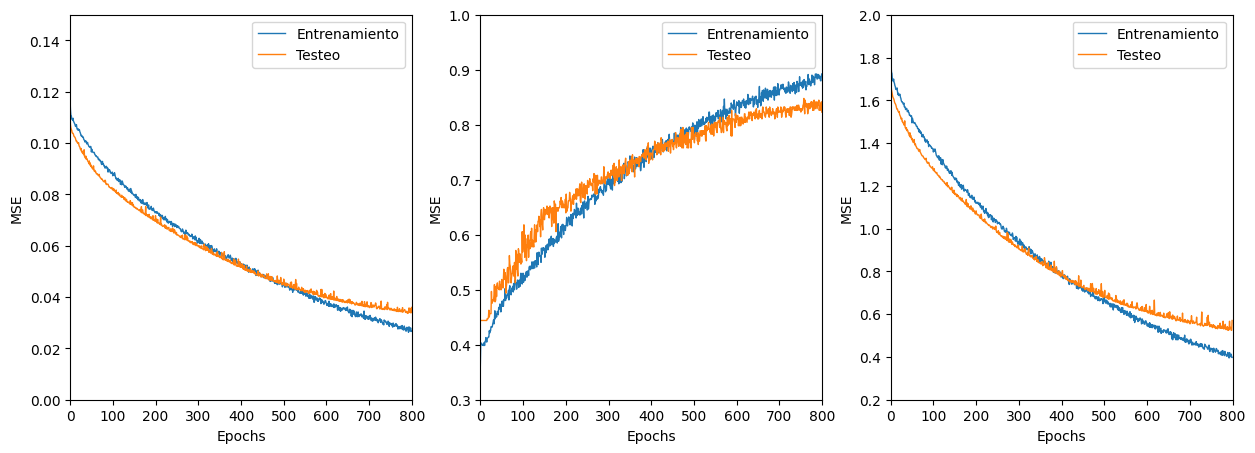

In [51]:
f = plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
grafico_comprobacion("mse", "val_mse", 0, 0.15)

plt.subplot(1,3,2)
grafico_comprobacion("acc", "val_acc", 0.3, 1)

plt.subplot(1,3,3)
grafico_comprobacion("loss", "val_loss", 0.2, 2)

plt.show()

In [52]:
acc_test = modelo.evaluate(x_test, y_test,verbose=0)
acc_entrenamiento = modelo.evaluate(x_entrenar, y_entrenar,verbose=0)

print(f"Accuracy sobre conjunto de entrenamiento: {acc_entrenamiento[1]}")
print(f"Accuracy sobre conjunto de validacion:{acc_test[1]}")

Accuracy sobre conjunto de entrenamiento: 0.9120082855224609
Accuracy sobre conjunto de validacion:0.8229813575744629


### PASO 6 - Predicciones y evaluacion con Matriz de Confusion

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Matriz de confusion
[[  9   6   3   1   0   0   0]
 [  2  49   1   2   1   0   1]
 [  1   2  21   1   1   0   2]
 [  0   6   4 125   4   0   4]
 [  0   0   0   1  19   1   4]
 [  0   2   0   0   1  10   3]
 [  0   0   0   1   2   0  32]]


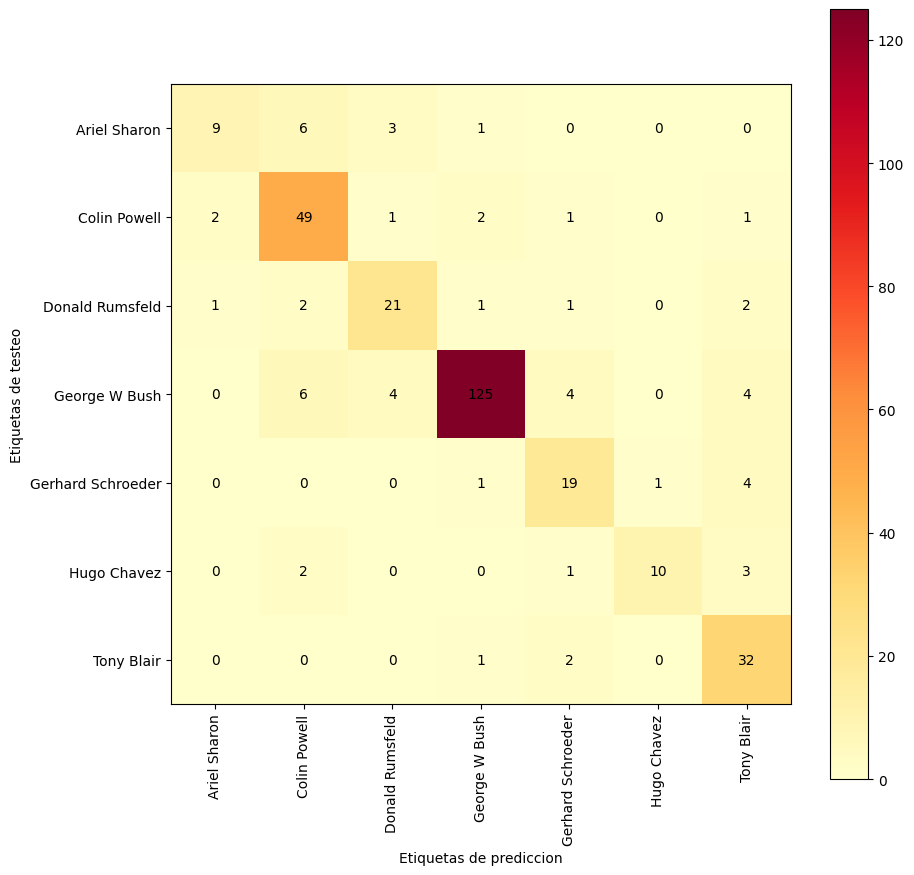

In [53]:
# Predicciones con la data de testeo
y_prediccion = modelo.predict(x_test, verbose=1)

# Matriz de confusion y grafica
y_test_cm = np.argmax(y_test, axis=1)
y_prediccion_cm = np.argmax(y_prediccion, axis=1)
confm = confusion_matrix(y_test_cm, y_prediccion_cm)
print(f"\nMatriz de confusion")
print(confm)

f = plt.figure(figsize=(10,10))
plt.imshow(confm, cmap="YlOrRd")
plt.xlabel("Etiquetas de prediccion")
plt.ylabel("Etiquetas de testeo")
plt.xticks(np.arange(7), target_names,rotation=90)
plt.yticks(np.arange(7), target_names,rotation=0)
for i in range(len(target_names)):
    for j in range(len(target_names)):
        text = plt.text(j, i, confm[i, j], ha="center", va="center", color="black")
plt.colorbar()
plt.show()


### PASO 7 - Otra verificacion



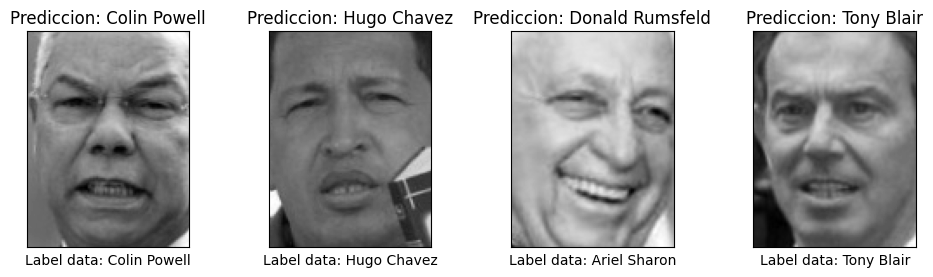

In [54]:
num = [23, 77, 101, 252]

plt.figure(figsize=(1.8 * 4, 2.4 * 1))
plt.subplots_adjust(bottom=0, left=0.01, right=1.3, top=0.90, hspace=0.35)
for i, j in enumerate(num):
    plt.subplot(1, 4, i + 1)
    plt.imshow(x_testeo[j], cmap=plt.cm.gray)
    plt.title(f"Prediccion: {target_names[y_prediccion_cm[j]]}", size=12)
    plt.xlabel(f"Label data: {target_names[y_test_cm[j]]}")
    plt.xticks(())
    plt.yticks(())

### PASO 8 - Conclusiones

Tras experimentar con diversas configuraciones, incluyendo el número de capas, la cantidad de neuronas en cada una y los hiperparámetros, logré establecer una estructura del modelo que supera los requisitos de precisión exigidos en el ejercicio.

Para evitar el sobreentrenamiento, integré dos capas con Dropout, lo que contribuyó significativamente a la estabilidad del modelo.

En los gráficos de validación correspondientes al MSE, Loss y Accuracy, observé líneas con fluctuaciones irregulares. Ajustando parámetros como el learning rate y el tamaño de batch size, logré reducir este ruido, mejorando el desempeño general del modelo.

Si bien las redes densas demostraron ser capaces de clasificar imágenes con precisión, fue necesario emplear un número elevado de epochs para alcanzar el rendimiento requerido. Esto incrementó considerablemente los tiempos de entrenamiento y el consumo computacional, en comparación con una red convolucional, que sería más eficiente para esta tarea.

La matriz de confusión muestra que la clasificación es altamente precisa; sin embargo, se observan algunos errores en las clasificaciones fuera de la diagonal principal.

Considero que la principal dificultad de este modelo para alcanzar la precisión deseada radica en la gran cantidad de datos de entrada, ya que el aplanamiento de la información en un vector unidimensional genera una mayor complejidad en el entrenamiento.